In [1]:

import os
import time
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, JitTraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex
from pyro.util import ignore_jit_warnings

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:
import cProfile as profile
import pstats
from numba import jit

In [3]:

import pandas as pd
import numpy as np

rtdata = pd.read_csv('mcfrt.csv')
#rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
5446,X,152500000,153000000,0.530530,66.362452,500000
5447,X,153000000,153500000,0.526266,74.503388,500000
5448,X,153500000,154000000,0.513464,75.837731,500000
5449,X,154000000,154500000,0.396106,61.508320,500000


In [4]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [5]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
gc = rtdata['gc'].values

num_cells0 = 50
num_loci0 = 50

num_cells1 = 100
num_loci1 = 100

num_cells2 = 200
num_loci2 = 200

num_cells3 = 500
num_loci3 = 500

num_cells4 = 1000
num_loci4 = 1000


### Play around with using true `cn` to create a reasonable CN prior (`cn_prob`) and a fixed transition matrix (`trans_mat`)

In [6]:
num_states = 13

# build the transition matrix using cn
def build_trans_mat(cn, num_states=13):
    num_loci, num_cells = cn.shape
    trans_mat = torch.eye(num_states, num_states) + 1
    for i in range(num_cells):
        for j in range(1, num_loci):
            cur_state = int(cn[j, i])
            prev_state = int(cn[j-1, i])
            trans_mat[prev_state, cur_state] += 1
    return trans_mat

def create_cn_prior(true_cn, weight=1e6, num_states=13):
    num_loci, num_cells = true_cn.shape
    cn_prior = torch.ones(num_loci, num_cells, num_states)
    for i in range(num_loci):
        for n in range(num_cells):
            state = int(true_cn[i, n].numpy())
            cn_prior[i, n, state] = weight
    return cn_prior


In [7]:
all_cn_priors = []
all_trans_mats = []
all_cns = []
all_gcs = []
all_starts = []
all_rts = []
for i in range(5):
    temp_n_loci = eval('num_loci{}'.format(i))
    for j in range(5):
        temp_n_cells = eval('num_cells{}'.format(j))
        temp_cn = torch.ones((temp_n_loci, temp_n_cells)) * 2
        temp_cn_prior = create_cn_prior(temp_cn, num_states=num_states)
        temp_trans_mat = build_trans_mat(temp_cn, num_states=num_states)
        
        temp_rt = torch.tensor(rt[:temp_n_loci])
        temp_gc = torch.tensor(gc[:temp_n_loci])
        temp_starts = starts[:temp_n_loci]
        
        temp_cn = temp_cn.type(torch.float32)
        temp_gc = temp_gc.type(torch.float32)
        temp_trans_mat = temp_trans_mat.type(torch.float32)
        temp_cn_prior = temp_cn_prior.type(torch.float32)
        temp_rt = temp_rt.type(torch.float32)
        
        all_cns.append(temp_cn)
        all_trans_mats.append(temp_trans_mat)
        all_cn_priors.append(temp_cn_prior)
        all_gcs.append(temp_gc)
        all_starts.append(temp_starts)
        all_rts.append(temp_rt)

all_cn_priors[1][0,0]

tensor([1.0000e+00, 1.0000e+00, 1.0000e+06, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00])

In [8]:
for cn in all_cns:
    print(cn.shape)
num_combos = len(all_cns)

torch.Size([50, 50])
torch.Size([50, 100])
torch.Size([50, 200])
torch.Size([50, 500])
torch.Size([50, 1000])
torch.Size([100, 50])
torch.Size([100, 100])
torch.Size([100, 200])
torch.Size([100, 500])
torch.Size([100, 1000])
torch.Size([200, 50])
torch.Size([200, 100])
torch.Size([200, 200])
torch.Size([200, 500])
torch.Size([200, 1000])
torch.Size([500, 50])
torch.Size([500, 100])
torch.Size([500, 200])
torch.Size([500, 500])
torch.Size([500, 1000])
torch.Size([1000, 50])
torch.Size([1000, 100])
torch.Size([1000, 200])
torch.Size([1000, 500])
torch.Size([1000, 1000])


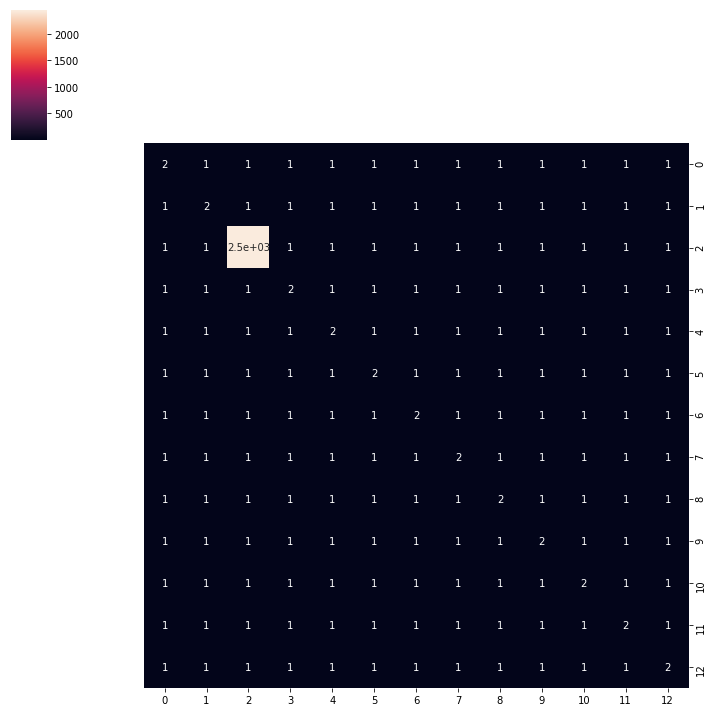

In [9]:
sns.clustermap(all_trans_mats[0].numpy(), col_cluster=False, row_cluster=False, annot=True)
plt.show()

### Define generative model for G1-phase cells

In [10]:
def make_gc_features(x, poly_degree=4):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in reversed(range(0, poly_degree+1))], 1)

softplus = torch.nn.Softplus()
relu = torch.nn.ReLU()

@config_enumerate
def model_g1(gc_profile, cn=None, num_cells=None, num_loci=None, data=None, u_guess=70., poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    betas = pyro.sample('expose_betas', dist.Normal(0., 1.).expand([poly_degree+1]).to_event(1))

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([u_guess]), torch.tensor([u_guess/10.])))

        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree)
            gc_rate = torch.exp(torch.sum(betas * gc_features, 1))
            biased_cn = cn * gc_rate.reshape(-1, 1)

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [11]:
pyro.clear_param_store()

conditioned_model_g1 = poutine.condition(
    model_g1,
    data={
        'expose_betas': torch.tensor([0.1, 0.2, -1, 1, -0.25])*10.,
    })

def simulate_g1_data(model, gc, cn):
    pyro.clear_param_store()
    model_trace_g1 = pyro.poutine.trace(model)
    samples_g1 = model_trace_g1.get_trace(gc, cn)

    betas_g1 = samples_g1.nodes['expose_betas']['value']
    u_g1 = samples_g1.nodes['expose_u']['value']
    nb_r_g1 = samples_g1.nodes['expose_nb_r']['value']
    reads_g1 = samples_g1.nodes['reads']['value']
    
    reads_per_cell = torch.mean(reads_g1) * cn.shape[0]
    reads_norm_g1 = (reads_g1 / torch.sum(reads_g1, 0)) * reads_per_cell
    
    reads_g1 = reads_g1.type(torch.float32)
    reads_norm_g1 = reads_norm_g1.type(torch.int64)
    reads_norm_g1 = reads_norm_g1.type(torch.float32)

    return betas_g1, u_g1, nb_r_g1, reads_g1, reads_norm_g1



In [12]:
all_betas_g1 = []
all_u_g1 = []
all_nbr_g1 = []
all_reads_g1 = []
all_reads_norm_g1 = []
for k in range(num_combos):
    print('gc', all_gcs[k].shape)
    print('cn', all_cns[k].shape)
    temp_betas, temp_u, temp_nbr, temp_reads, temp_reads_norm = simulate_g1_data(conditioned_model_g1, all_gcs[k], all_cns[k])
    all_betas_g1.append(temp_betas)
    all_u_g1.append(temp_u)
    all_nbr_g1.append(temp_nbr)
    all_reads_g1.append(temp_reads)
    all_reads_norm_g1.append(temp_reads_norm)
    

gc torch.Size([50])
cn torch.Size([50, 50])
gc torch.Size([50])
cn torch.Size([50, 100])
gc torch.Size([50])
cn torch.Size([50, 200])
gc torch.Size([50])
cn torch.Size([50, 500])
gc torch.Size([50])
cn torch.Size([50, 1000])
gc torch.Size([100])
cn torch.Size([100, 50])
gc torch.Size([100])
cn torch.Size([100, 100])
gc torch.Size([100])
cn torch.Size([100, 200])
gc torch.Size([100])
cn torch.Size([100, 500])
gc torch.Size([100])
cn torch.Size([100, 1000])
gc torch.Size([200])
cn torch.Size([200, 50])
gc torch.Size([200])
cn torch.Size([200, 100])
gc torch.Size([200])
cn torch.Size([200, 200])
gc torch.Size([200])
cn torch.Size([200, 500])
gc torch.Size([200])
cn torch.Size([200, 1000])
gc torch.Size([500])
cn torch.Size([500, 50])
gc torch.Size([500])
cn torch.Size([500, 100])
gc torch.Size([500])
cn torch.Size([500, 200])
gc torch.Size([500])
cn torch.Size([500, 500])
gc torch.Size([500])
cn torch.Size([500, 1000])
gc torch.Size([1000])
cn torch.Size([1000, 50])
gc torch.Size([1000])


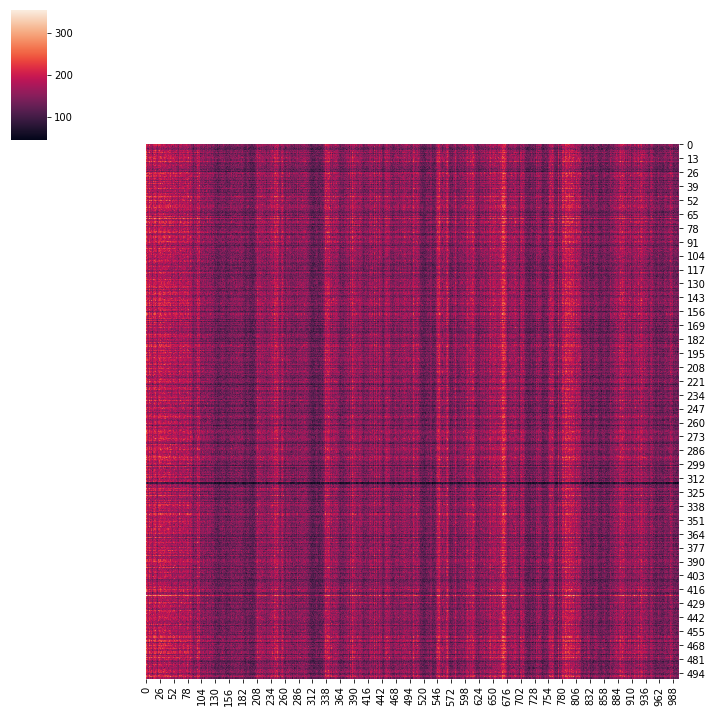

In [13]:
sns.clustermap(all_reads_g1[23].numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

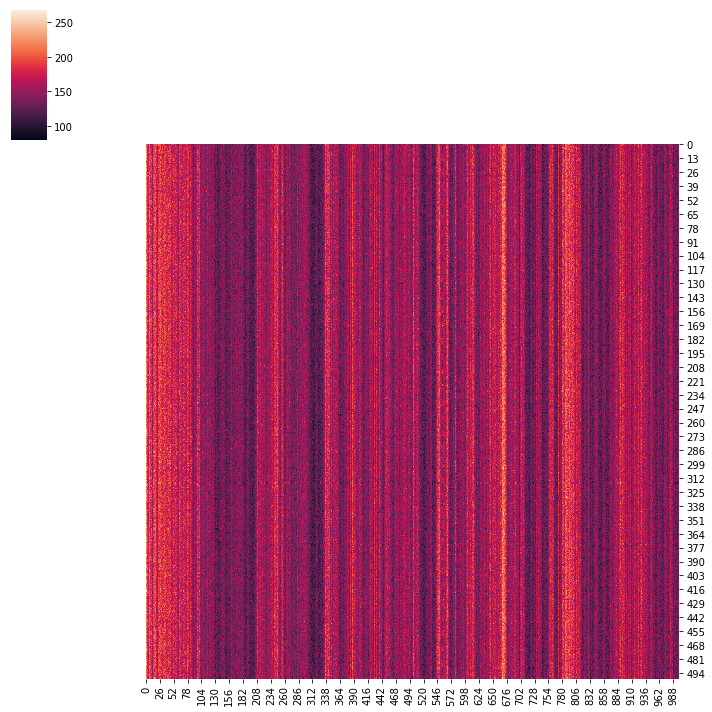

In [14]:
sns.clustermap(all_reads_norm_g1[23].numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

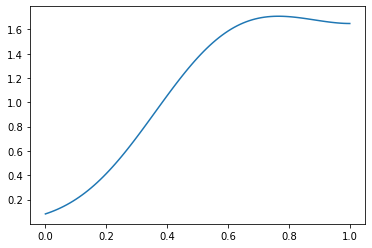

In [15]:
x = np.linspace(0, 1, 101)  # gc values

p1d = np.poly1d(all_betas_g1[0])
mean = np.exp(p1d(x))

plt.plot(x, mean)

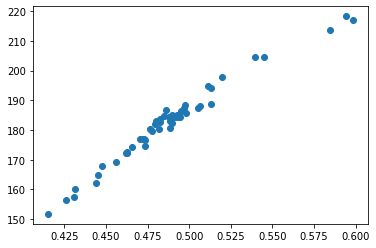

In [16]:
plt.scatter(x=all_gcs[0], y=torch.mean(all_reads_g1[0], dim=1))
plt.show()

### Infer parameters using G1-phase model

Only infer parameters for one of the 25 dataset sizes

TODO: make sure parameter names match the new names above

In [17]:
# cn = cn.type(torch.float32)
# reads_g1 = reads_g1.type(torch.float32)
# reads_norm_g1 = reads_norm_g1.type(torch.float32)
# gc = gc.type(torch.float32)

In [18]:
conditioned_model_g1 = poutine.condition(
    model_g1,
    data={
#         'expose_betas': torch.tensor([0.1, 0.2, -1, 1, -0.25])*10.,
#         'expose_nb_r': 10000.0,
#         'expose_u': all_u_g1[23]
    })

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)

guide_g1 = AutoDelta(
    poutine.block(conditioned_model_g1, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model_g1, guide_g1, optim, loss=elbo)


In [19]:
u_guess_g1 = torch.mean(all_reads_norm_g1[23]) / torch.mean(all_cns[23])

In [20]:
# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model_g1, guide_g1, all_gcs[23], cn=all_cns[23], data=all_reads_norm_g1[23], u_guess=u_guess_g1)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py:356: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  "TraceEnum_ELBO found no sample sites configured for enumeration. "


6603961.5

In [21]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(all_gcs[23], cn=all_cns[23], data=all_reads_norm_g1[23], u_guess=u_guess_g1)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

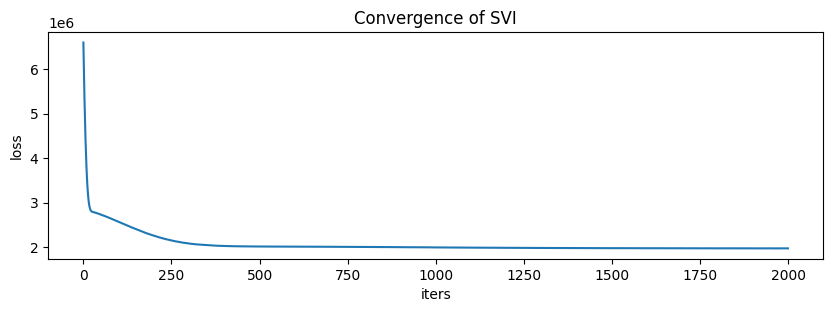

In [22]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [23]:
# replay model
guide_trace_g1 = poutine.trace(guide_g1).get_trace(all_gcs[23], cn=all_cns[23], data=all_reads_norm_g1[23], u_guess=u_guess_g1)
trained_model_g1 = poutine.replay(model_g1, trace=guide_trace_g1)

# infer discrete sites and get model trace
inferred_model_g1 = infer_discrete(
    trained_model_g1, temperature=0,
    first_available_dim=-3)
trace_g1 = poutine.trace(inferred_model_g1).get_trace(all_gcs[23], cn=all_cns[23], data=all_reads_norm_g1[23], u_guess=u_guess_g1)

# extract fitted parameters
nb_r_fit = trace_g1.nodes['expose_nb_r']['value']
betas_fit = trace_g1.nodes['expose_betas']['value']
u_fit = trace_g1.nodes['expose_u']['value']

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/discrete.py:99: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  "infer_discrete found no sample sites configured for enumeration. "


In [24]:
betas_fit

tensor([-4.9986, -0.3283,  2.6514,  2.3591, -1.2520],
       grad_fn=<ExpandBackward0>)

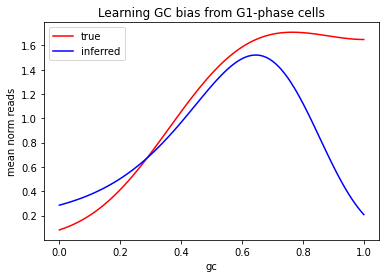

In [25]:
x = np.linspace(0, 1, 101)  # gc values

# plt.scatter(x=gc, y=torch.mean(reads_g1, dim=1))

# true gc betas
p1d = np.poly1d(all_betas_g1[23])
mean = np.exp(p1d(x))
plt.plot(x, mean, 'r', label='true')

# inferred gc betas
p1d_fit = np.poly1d(betas_fit.detach().numpy())
mean_fit = np.exp(p1d_fit(x))
plt.plot(x, mean_fit, 'b', label='inferred')

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from G1-phase cells')
plt.legend()
plt.show()

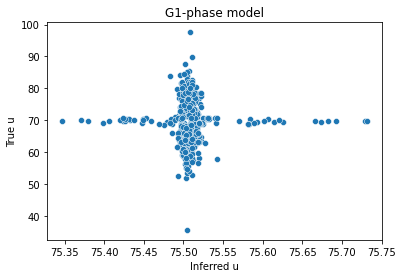

In [26]:
sns.scatterplot(x=u_fit.detach().numpy(), y=all_u_g1[23].detach().numpy())
plt.xlabel('Inferred u')
plt.ylabel('True u')
plt.title('G1-phase model')
plt.show()

In [27]:
nb_r_fit

tensor([4218.5796], grad_fn=<AddBackward0>)

In [28]:
all_nbr_g1[23]

tensor([10000.0010], grad_fn=<AddBackward0>)

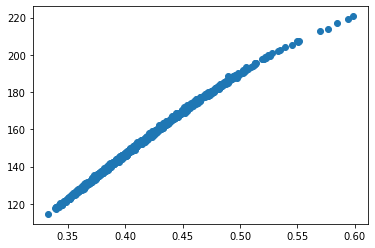

In [29]:
plt.scatter(x=all_gcs[23], y=torch.mean(all_reads_norm_g1[23], dim=1))
plt.show()

### TODO: run inference model for 200 iters across all 25 dataset sizes

With and without JIT
Track runtime of each case --> plot


In [30]:
%%capture
g1_runtime_df = []
num_iters = 200
for n in range(25):
    for jit in [True, False]:
        
        conditioned_model_g1 = poutine.condition(
            model_g1,
            data={}
        )
        optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
        
        if jit:
            elbo = JitTraceEnum_ELBO(max_plate_nesting=2)
        else:
            elbo = TraceEnum_ELBO(max_plate_nesting=2)
        
        guide_g1 = AutoDelta(
            poutine.block(conditioned_model_g1, expose_fn=lambda msg: msg["name"].startswith("expose_"))
        )
        svi = SVI(conditioned_model_g1, guide_g1, optim, loss=elbo)
        u_guess_g1 = torch.mean(all_reads_norm_g1[n]) / torch.mean(all_cns[n])
        pyro.clear_param_store()
        elbo.loss(conditioned_model_g1, guide_g1, all_gcs[n], cn=all_cns[n], data=all_reads_norm_g1[n], u_guess=u_guess_g1)

        pyro.clear_param_store()

        start_time = time.time()
        for i in range(num_iters):
            loss = svi.step(all_gcs[n], cn=all_cns[n], data=all_reads_norm_g1[n], u_guess=u_guess_g1)
            if i == 20:
                first_iter_time = time.time()
        end_time = time.time()
        time_early_iters = first_iter_time - start_time
        time_late_iters = end_time - first_iter_time
        elapsed_time = end_time - start_time
        sec_per_iter = time_late_iters / num_iters
        
        temp_df = pd.DataFrame({'num_cells': [all_cns[n].shape[1]], 'num_loci': [all_cns[n].shape[0]],
                                'jit': [jit], 'iters_20-200': [time_late_iters], 'sec_per_iter': [sec_per_iter],
                                'iters_1-20': [time_early_iters], 'total_elapsed_time': [elapsed_time],
                                'num_iters': [num_iters]
                               })
        g1_runtime_df.append(temp_df)
        
        print('.' if i % 80 else '\n', end='')

g1_runtime_df = pd.concat(g1_runtime_df, ignore_index=True)

In [31]:
g1_runtime_df['num_bins'] = g1_runtime_df['num_cells'] * g1_runtime_df['num_loci']
g1_runtime_df.head()

,num_cells,num_loci,jit,iters_20-200,sec_per_iter,iters_1-20,total_elapsed_time,num_iters,num_bins
0,50,50,True,0.586987,0.002935,1.343631,1.930618,200,2500
1,50,50,False,1.189533,0.005948,0.145338,1.334872,200,2500
2,100,50,True,0.558078,0.002790,1.366835,1.924912,200,5000
3,100,50,False,1.216204,0.006081,0.148332,1.364536,200,5000
4,200,50,True,0.765965,0.003830,1.311540,2.077505,200,10000


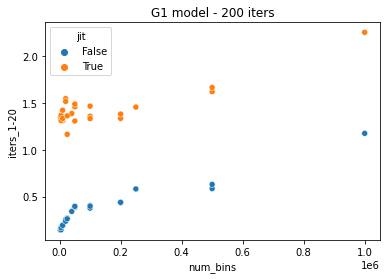

In [32]:
sns.scatterplot(data=g1_runtime_df, x='num_bins', y='iters_1-20', hue='jit')
plt.title('G1 model - {} iters'.format(num_iters))
plt.show()

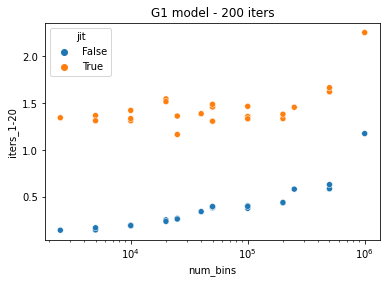

In [33]:
sns.scatterplot(data=g1_runtime_df, x='num_bins', y='iters_1-20', hue='jit')
plt.title('G1 model - {} iters'.format(num_iters))
plt.xscale('log')
plt.show()

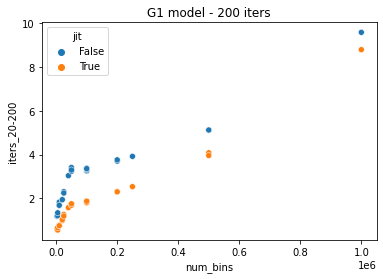

In [34]:
sns.scatterplot(data=g1_runtime_df, x='num_bins', y='iters_20-200', hue='jit')
plt.title('G1 model - {} iters'.format(num_iters))
plt.show()

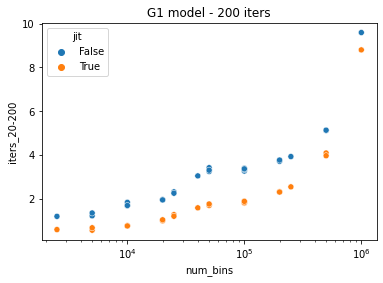

In [35]:
sns.scatterplot(data=g1_runtime_df, x='num_bins', y='iters_20-200', hue='jit')
plt.title('G1 model - {} iters'.format(num_iters))
plt.xscale('log')
plt.show()

### Define generative model for S-phase cells

In [36]:

@config_enumerate
def model_S(gc_profile, betas=None, cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, trans_mat=None, cn_prior=None, u_guess=70., nb_r_guess=10000.):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn0 is not None:
            num_loci, num_cells = cn0.shape
        assert num_cells is not None
        assert num_loci is not None

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([nb_r_guess]), constraint=constraints.positive)
    
    # transition probabilities for HMM
    if trans_mat is None:
        trans_mat = pyro.sample('expose_trans_prob',
                                dist.Dirichlet(0.99 * torch.eye(13) + 0.01).to_event(1))
    
    # gc bias params
    if betas is None:
        poly_degree = 4
        betas = pyro.sample('expose_betas', dist.Normal(0., 1.).expand([poly_degree+1]).to_event(1))
    else:
        poly_degree = betas.shape[0]-1

    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        time = pyro.sample('expose_time', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([u_guess]), torch.tensor([u_guess/7.])))
        
        # starting states for markov chain
        if cn0 is None:
            cn = 2

        for l in pyro.markov(range(num_loci)):

            # sample copy number states using HMM structure
            if cn0 is None:
                temp_cn_prob = trans_mat[cn]
                if cn_prior is not None:
                    temp_cn_prob = temp_cn_prob * cn_prior[l]
                cn = pyro.sample("cn_{}".format(l), dist.Categorical(temp_cn_prob),
                                 infer={"enumerate": "parallel"})
            else:
                # no need to sample cn when true cn0 is provided to the model
                cn = cn0[l]
                
            # per cell per bin late or early 
            time_diff = time.reshape(-1, num_cells) - rt[l]

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * time_diff))

            # binary replicated indicator
            rep = pyro.sample('rep_{}'.format(l), dist.Bernoulli(p_rep))
            
            # copy number accounting for replication
            rep_cn = cn * (1. + rep)
            
            # copy number accounting for gc bias
            gc_features = make_gc_features(torch.tensor([gc_profile[l]]), poly_degree=poly_degree)
            gc_rate = torch.exp(torch.sum(betas * gc_features, 1))
            biased_cn = rep_cn * gc_rate.reshape(-1, 1)

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            
            if data is not None:
                obs = data[l]
            else:
                obs = None
            
            reads = pyro.sample('reads_{}'.format(l), dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

# trace = poutine.trace(model_S).get_trace(cn, rt, num_cells=num_cells)
# trace.compute_log_prob()
# print(trace.format_shapes())
# pyro.render_model(model_S, model_args=(cn, rt, num_cells), 
#                   render_distributions=True, render_params=True)

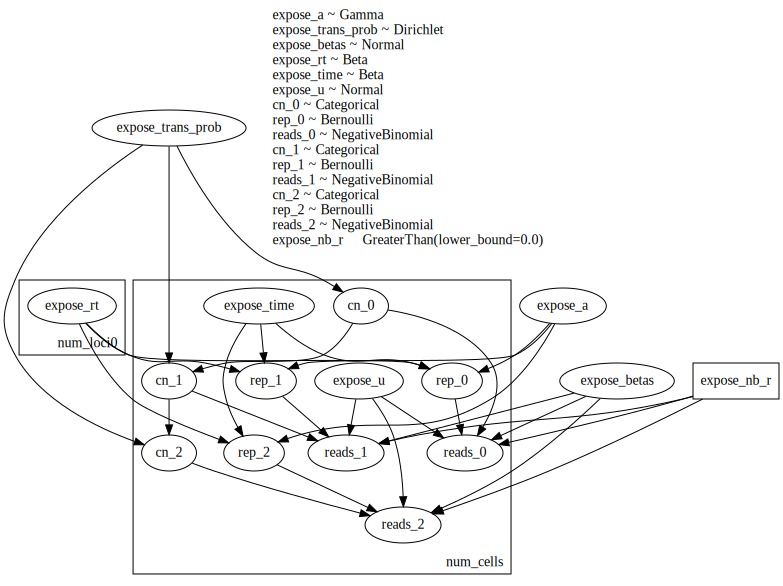

In [37]:
# trace = poutine.trace(model_S).get_trace(None, num_cells=num_cells, num_loci=num_loci)
# trace.compute_log_prob()
# print(trace.format_shapes())
pyro.render_model(model_S, model_args=(all_gcs[23][:3], None, None, None, 100, 3), 
                  render_distributions=True, render_params=True)

### Simulate and visualize data

TODO: simulate for all 25 dataset sizes like I did for G1-phase cells

In [38]:
pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S,
    data={
        'expose_a': torch.tensor([10.]),
    })

def simulate_s_data(model, gc, cn, betas_g1, rt):
    pyro.clear_param_store()
    num_loci, num_cells = cn.shape
    model_trace = pyro.poutine.trace(model)
    samples = model_trace.get_trace(gc, betas_g1, cn, rt, num_cells=num_cells)

    time = samples.nodes['expose_time']['value']
    a = samples.nodes['expose_a']['value']
    u = samples.nodes['expose_u']['value']
    nb_r = samples.nodes['expose_nb_r']['value']

    time_diff = time.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
    p_rep = 1 / (1 + torch.exp(-a * time_diff))

    rep = torch.zeros(cn.shape)
    rep_cn = torch.zeros(cn.shape)
    reads = torch.zeros(cn.shape)
    for l in range(num_loci):
        temp_rep = samples.nodes['rep_{}'.format(l)]['value']
        temp_rep_cn = cn[l] * (1. + temp_rep)
        temp_reads = samples.nodes['reads_{}'.format(l)]['value']
        rep[l] = temp_rep
        rep_cn[l] = temp_rep_cn
        reads[l] = temp_reads
    
    reads_per_cell = torch.mean(reads) * num_loci
    reads_norm = (reads / torch.sum(reads, 0)) * reads_per_cell
    
    reads = reads.type(torch.float32)
    reads_norm = reads_norm.type(torch.int64)
    reads_norm = reads_norm.type(torch.float32)

    return time, a, u, nb_r, p_rep, rep, rep_cn, reads, reads_norm


In [39]:
all_times_s = []
all_a_s = []
all_u_s = []
all_nbr_s = []
all_prep_s = []
all_rep_s = []
all_repcn_s = []
all_reads_s = []
all_reads_norm_s = []
for k in range(num_combos):
    print('gc', all_gcs[k].shape)
    print('cn', all_cns[k].shape)
    temp_time, temp_a, temp_u, temp_nb_r, temp_p_rep, temp_rep, temp_rep_cn, temp_reads, temp_reads_norm = simulate_s_data(
        conditioned_model, all_gcs[k], all_cns[k], all_betas_g1[k], all_rts[k]
    )
    all_times_s.append(temp_time)
    all_a_s.append(temp_a)
    all_u_s.append(temp_u)
    all_nbr_s.append(temp_nb_r)
    all_prep_s.append(temp_p_rep)
    all_rep_s.append(temp_rep)
    all_repcn_s.append(temp_rep_cn)
    all_reads_s.append(temp_reads)
    all_reads_norm_s.append(temp_reads_norm)

gc torch.Size([50])
cn torch.Size([50, 50])
gc torch.Size([50])
cn torch.Size([50, 100])
gc torch.Size([50])
cn torch.Size([50, 200])
gc torch.Size([50])
cn torch.Size([50, 500])
gc torch.Size([50])
cn torch.Size([50, 1000])
gc torch.Size([100])
cn torch.Size([100, 50])
gc torch.Size([100])
cn torch.Size([100, 100])
gc torch.Size([100])
cn torch.Size([100, 200])
gc torch.Size([100])
cn torch.Size([100, 500])
gc torch.Size([100])
cn torch.Size([100, 1000])
gc torch.Size([200])
cn torch.Size([200, 50])
gc torch.Size([200])
cn torch.Size([200, 100])
gc torch.Size([200])
cn torch.Size([200, 200])
gc torch.Size([200])
cn torch.Size([200, 500])
gc torch.Size([200])
cn torch.Size([200, 1000])
gc torch.Size([500])
cn torch.Size([500, 50])
gc torch.Size([500])
cn torch.Size([500, 100])
gc torch.Size([500])
cn torch.Size([500, 200])
gc torch.Size([500])
cn torch.Size([500, 500])
gc torch.Size([500])
cn torch.Size([500, 1000])
gc torch.Size([1000])
cn torch.Size([1000, 50])
gc torch.Size([1000])


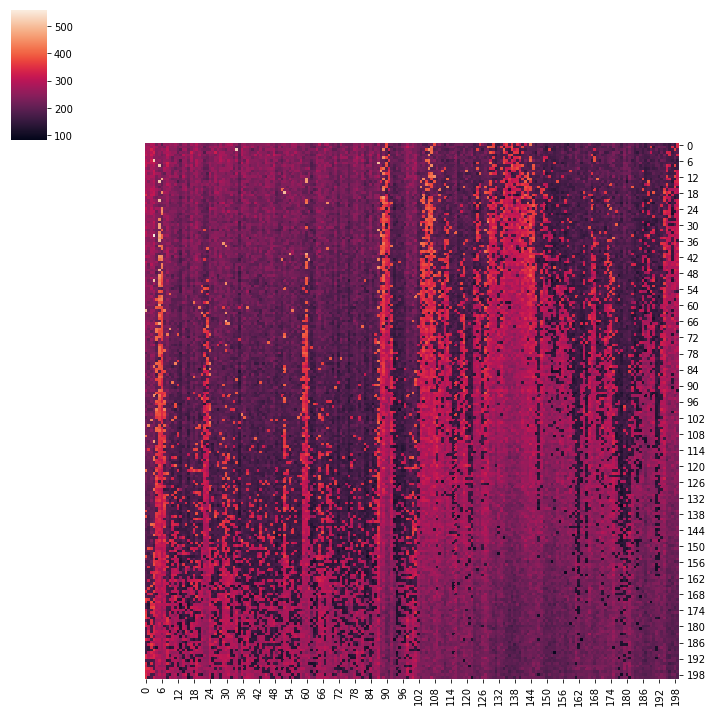

In [40]:
sns.clustermap(all_reads_norm_s[12].numpy().astype(float).T[np.argsort(all_times_s[12]), :], col_cluster=False, row_cluster=False)
plt.show()

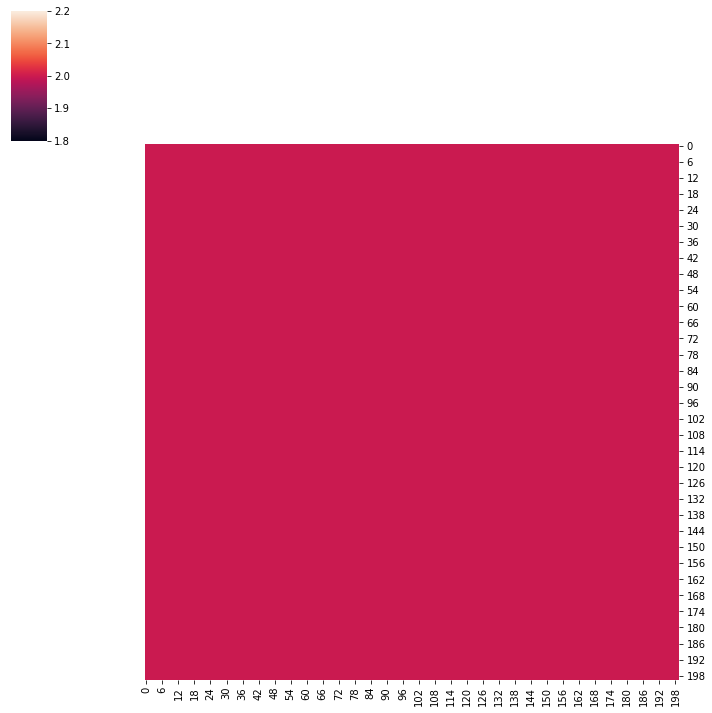

In [41]:
# visualize true cn matrix
sns.clustermap(all_cns[12].numpy().astype(float).T[np.argsort(all_times_s[12]), :], col_cluster=False, row_cluster=False)
plt.show()

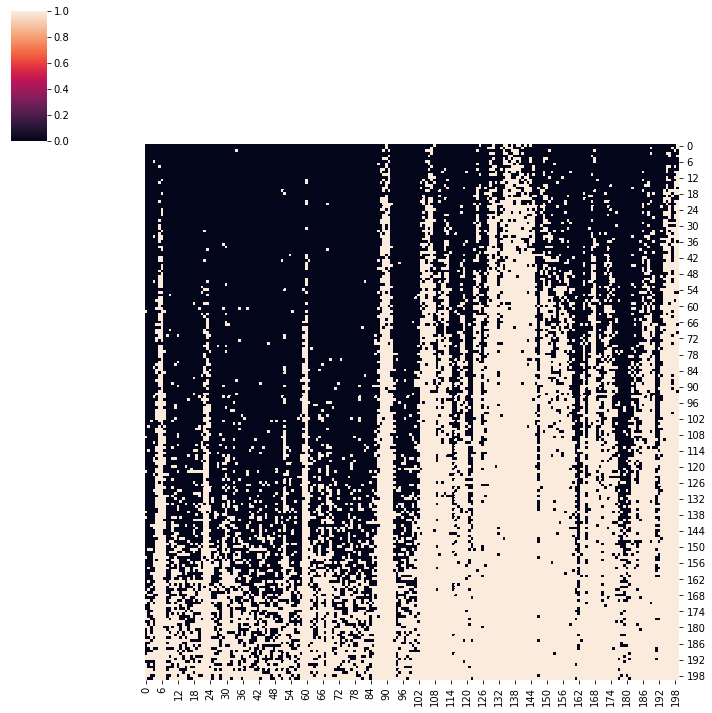

In [42]:
# visualize true cn matrix
sns.clustermap(all_rep_s[12].numpy().astype(float).T[np.argsort(all_times_s[12]), :], col_cluster=False, row_cluster=False)
plt.show()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


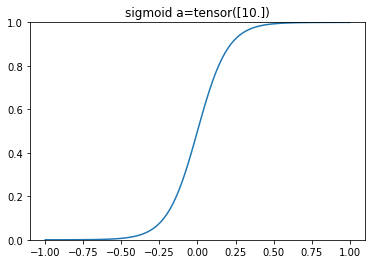

In [43]:
def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(all_a_s[12])


### Run inference on just one S-phase dataset

TODO: make sure param names match

In [44]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
# elbo = JitTraceEnum_ELBO(max_plate_nesting=1)
elbo = TraceEnum_ELBO(max_plate_nesting=1)


In [45]:
# condition_dict = {}
# for l in range(num_loci):
#     condition_dict['rep_{}'.format(l)] = torch.zeros(num_cells)
# condition_dict

In [46]:

conditioned_model = poutine.condition(
    model_S,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
    })

# conditioned_model_G1 = poutine.condition(
#     model_S,
#     data=condition_dict
# )

guide = AutoDelta(
    poutine.block(conditioned_model, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [47]:

# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model, guide, all_gcs[12], betas=all_betas_g1[12], data=all_reads_norm_s[12], 
          trans_mat=all_trans_mats[12], cn_prior=all_cn_priors[12])

# %lprun -f elbo.loss elbo.loss(conditioned_model, guide, gc, betas=betas_g1, data=reads_norm, trans_mat=trans_mat, cn_prior=cn_prior)


332423.8125

In [48]:

# Learn the model and guide params

pyro.clear_param_store()

# prof = profile.Profile()
# prof.enable()

losses = []
for i in range(2000):
    loss = svi.step(all_gcs[12], betas=all_betas_g1[12], data=all_reads_norm_s[12], 
                    trans_mat=all_trans_mats[12], cn_prior=all_cn_priors[12])
    losses.append(loss)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    print('.' if i % 80 else '\n', end='')

# prof.disable()
# stats = pstats.Stats(prof).strip_dirs().sort_stats("cumtime")
# stats.print_stats() # top 10 rows


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

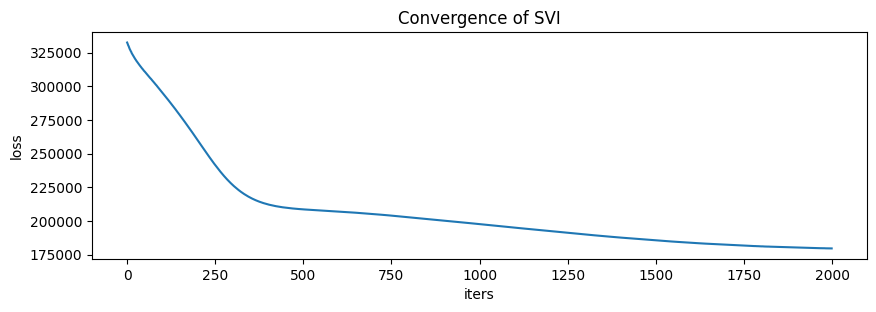

In [49]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


### Visualize model output results for `rep` and `cn`

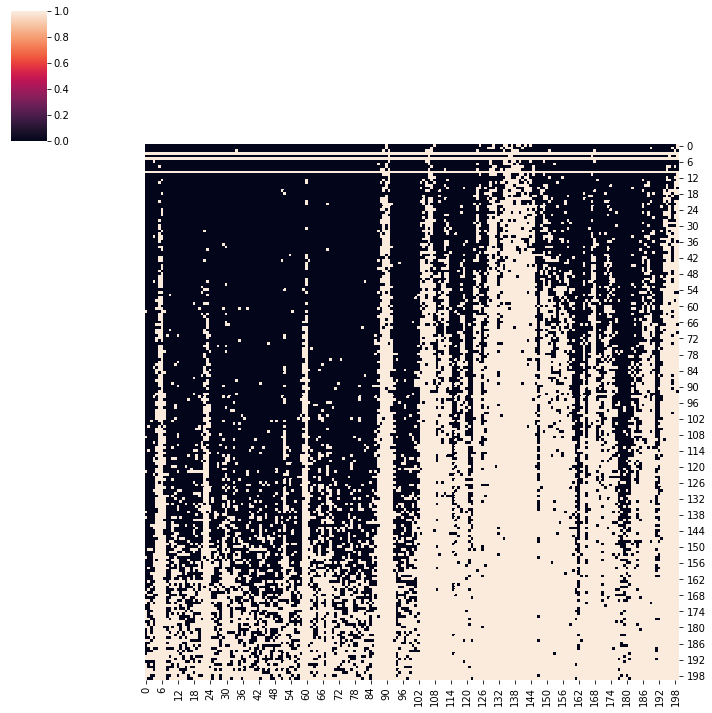

In [50]:

# Plot replicated state

guide_trace = poutine.trace(guide).get_trace(all_gcs[12], betas=all_betas_g1[12], data=all_reads_norm_s[12], 
                                             trans_mat=all_trans_mats[12], cn_prior=all_cn_priors[12])
trained_model = poutine.replay(conditioned_model, trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-2)
trace = poutine.trace(inferred_model).get_trace(all_gcs[12], betas=all_betas_g1[12], data=all_reads_norm_s[12], 
                                                trans_mat=all_trans_mats[12], cn_prior=all_cn_priors[12])

model_rep = torch.zeros(all_cns[12].shape)
model_cn = torch.zeros(all_cns[12].shape)
model_rep_cn = torch.zeros(all_cns[12].shape)
model_reads = torch.zeros(all_cns[12].shape)
for l in range(all_cns[12].shape[0]):
    temp_rep = trace.nodes['rep_{}'.format(l)]['value']
    temp_cn = trace.nodes['cn_{}'.format(l)]['value']
    temp_rep_cn = temp_cn * (1. + temp_rep)
    temp_reads = trace.nodes['reads_{}'.format(l)]['value']
    model_rep[l] = temp_rep
    model_cn[l] = temp_cn
    model_rep_cn[l] = temp_rep_cn
    model_reads[l] = temp_reads

    
sns.clustermap(model_rep.numpy().astype(float).T[np.argsort(all_times_s[12]), :],
               col_cluster=False, row_cluster=False)

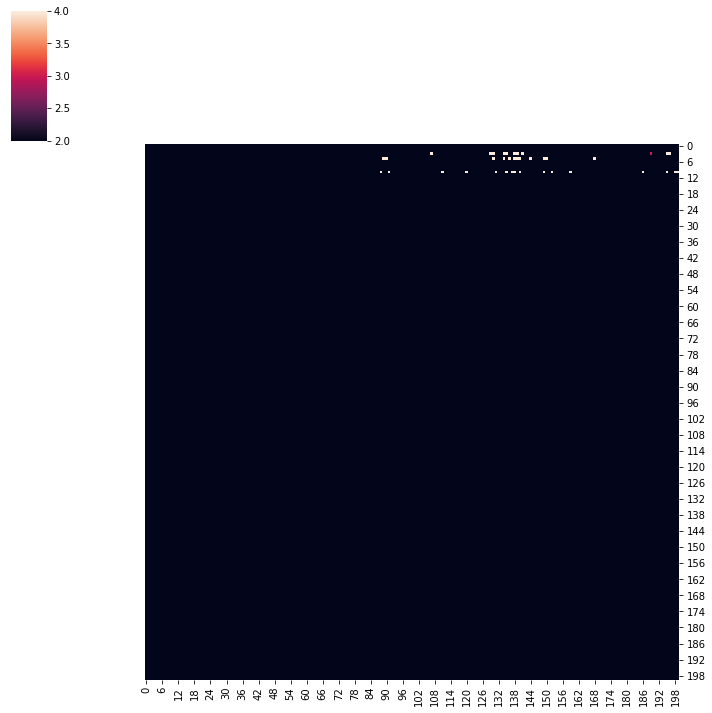

In [51]:
sns.clustermap(model_cn.numpy().astype(float).T[np.argsort(all_times_s[12]), :],
               col_cluster=False, row_cluster=False)
plt.show()

In [52]:
map_estimates = guide(all_gcs[12], betas=all_betas_g1[12], data=all_reads_norm_s[12], 
                      trans_mat=all_trans_mats[12], cn_prior=all_cn_priors[12])

In [53]:
map_estimates.keys()

dict_keys(['expose_a', 'expose_rt', 'expose_time', 'expose_u'])

In [54]:
map_estimates['expose_time'].shape

torch.Size([200])

In [55]:
map_estimates['expose_rt'].shape

torch.Size([200])

In [56]:
# compute p_rep for each bin using t, rt, and a
time_diff = trace.nodes['expose_time']['value'].reshape(-1, all_cns[12].shape[1]) - trace.nodes['expose_rt']['value'].reshape(all_cns[12].shape[0], -1)
p_rep = 1 / (1 + torch.exp(-trace.nodes['expose_a']['value'] * time_diff))
p_rep = p_rep.detach().numpy().astype(float)
p_rep.shape

(200, 200)

In [57]:
rep_maxprob = np.zeros(p_rep.shape)
for i in range(rep_maxprob.shape[0]):
    for j in range(rep_maxprob.shape[1]):
        rep_maxprob[i, j] = 1 if p_rep[i, j] > 0.5 else 0

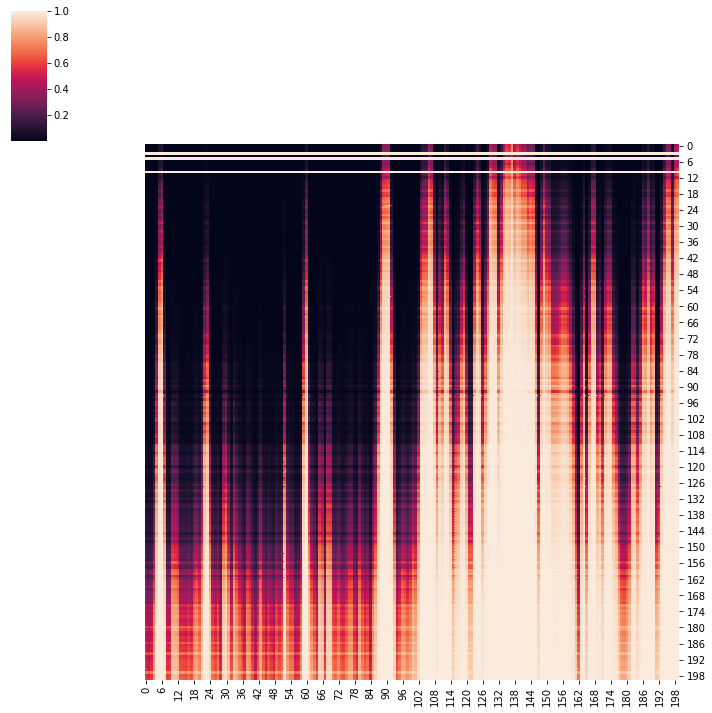

In [58]:
sns.clustermap(p_rep.T[np.argsort(all_times_s[12]), :],
               col_cluster=False, row_cluster=False)
plt.show()

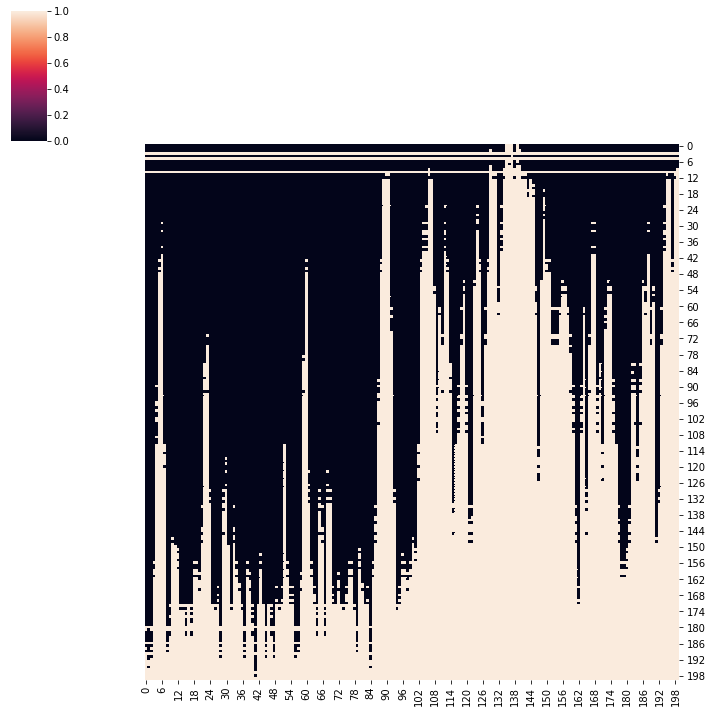

In [59]:
sns.clustermap(rep_maxprob.T[np.argsort(all_times_s[12]), :],
               col_cluster=False, row_cluster=False)
plt.show()

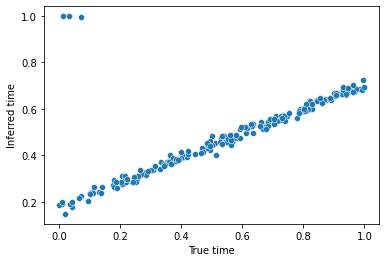

In [60]:

sns.scatterplot(
    x=all_times_s[12],
    y=map_estimates['expose_time'].detach().numpy(),
)
plt.xlabel('True time')
plt.ylabel('Inferred time')
plt.show()

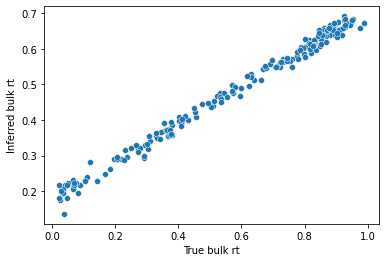

In [61]:
sns.scatterplot(
    x=all_rts[12],
    y=map_estimates['expose_rt'].detach().numpy(),
)
plt.xlabel('True bulk rt')
plt.ylabel('Inferred bulk rt')
plt.show()

In [62]:
model1_accuracy = 1.0 - (np.sum(abs(all_rep_s[12].numpy() - model_rep.numpy())) / (all_rep_s[12].shape[0] * all_rep_s[12].shape[1]))
model1_accuracy

0.985975

In [63]:
model1_maxprob_accuracy = 1.0 - (np.sum(abs(all_rep_s[12].numpy() - rep_maxprob)) / (all_rep_s[12].shape[0] * all_rep_s[12].shape[1]))
model1_maxprob_accuracy

0.866675

### TODO: runtime experiment across all 25 samples

Same logic as with G1-phase cells
Should be slower bc of HMM

In [69]:
# %%capture
s_runtime_df = []
num_iters = 20
for n in range(25):
    for jit in [False]:
        
        conditioned_model_s = poutine.condition(
            model_S,
            data={}
        )
        optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
        
        if jit:
            elbo = JitTraceEnum_ELBO(max_plate_nesting=1)
        else:
            elbo = TraceEnum_ELBO(max_plate_nesting=1)
        
        guide = AutoDelta(
            poutine.block(conditioned_model_s, expose_fn=lambda msg: msg["name"].startswith("expose_"))
        )
        svi = SVI(conditioned_model_s, guide, optim, loss=elbo)
        u_guess_s = torch.mean(all_reads_norm_s[n]) / torch.mean(all_cns[n])
        
        pyro.clear_param_store()
        elbo.loss(conditioned_model_s, guide, all_gcs[n], betas=all_betas_g1[n], data=all_reads_norm_s[n], 
                  trans_mat=all_trans_mats[n], cn_prior=all_cn_priors[n])

        pyro.clear_param_store()
        
        
        start_time = time.time()
        for i in range(num_iters):
            loss = svi.step(all_gcs[n], betas=all_betas_g1[n], data=all_reads_norm_s[n], 
                            trans_mat=all_trans_mats[n], cn_prior=all_cn_priors[n])
            if i == 1:
                first_iter_time = time.time()
        end_time = time.time()
        time_early_iters = first_iter_time - start_time
        time_late_iters = end_time - first_iter_time
        elapsed_time = end_time - start_time
        sec_per_iter = elapsed_time / num_iters
        
        temp_df = pd.DataFrame({'num_cells': [all_cns[n].shape[1]], 'num_loci': [all_cns[n].shape[0]],
                                'jit': [jit], 'iters_2-20': [time_late_iters], 'sec_per_iter': [sec_per_iter],
                                'iter_1': [time_early_iters], 'total_elapsed_time': [elapsed_time],
                                'num_iters': [num_iters]
                               })
        s_runtime_df.append(temp_df)
        
        print('done with condition {} and jit=={}'.format(n, jit))

s_runtime_df = pd.concat(s_runtime_df, ignore_index=True)

done with condition 0 and jit==False
done with condition 1 and jit==False
done with condition 2 and jit==False
done with condition 3 and jit==False
done with condition 4 and jit==False
done with condition 5 and jit==False
done with condition 6 and jit==False
done with condition 7 and jit==False
done with condition 8 and jit==False
done with condition 9 and jit==False
done with condition 10 and jit==False
done with condition 11 and jit==False
done with condition 12 and jit==False
done with condition 13 and jit==False
done with condition 14 and jit==False
done with condition 15 and jit==False
done with condition 16 and jit==False
done with condition 17 and jit==False
done with condition 18 and jit==False
done with condition 19 and jit==False
done with condition 20 and jit==False
done with condition 21 and jit==False
done with condition 22 and jit==False
done with condition 23 and jit==False
done with condition 24 and jit==False


In [70]:
s_runtime_df['num_bins'] = s_runtime_df['num_cells'] * s_runtime_df['num_loci']
s_runtime_df.head()

,num_cells,num_loci,jit,iters_2-20,sec_per_iter,iter_1,total_elapsed_time,num_iters,num_bins
0,50,50,False,4.969073,0.279380,0.618526,5.587600,20,2500
1,100,50,False,6.223341,0.342099,0.618640,6.841981,20,5000
2,200,50,False,8.376147,0.461725,0.858349,9.234496,20,10000
3,500,50,False,10.971994,0.607045,1.168905,12.140900,20,25000
4,1000,50,False,13.368681,0.738924,1.409807,14.778488,20,50000


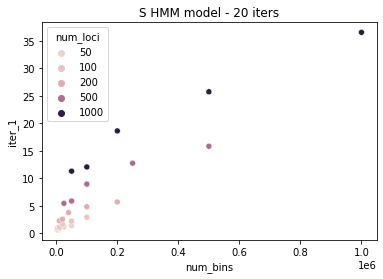

In [74]:
sns.scatterplot(data=s_runtime_df, x='num_bins', y='iter_1', hue='num_loci')
plt.title('S HMM model - {} iters'.format(num_iters))
plt.show()

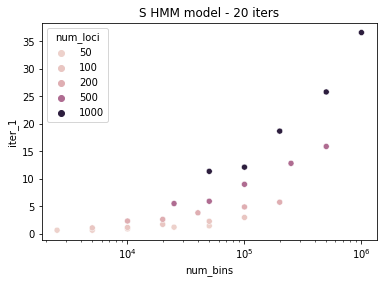

In [73]:
sns.scatterplot(data=s_runtime_df, x='num_bins', y='iter_1', hue='num_loci')
plt.title('S HMM model - {} iters'.format(num_iters))
plt.xscale('log')
plt.show()

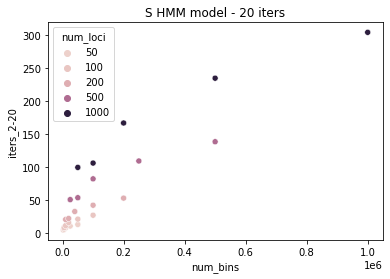

In [75]:
sns.scatterplot(data=s_runtime_df, x='num_bins', y='iters_2-20', hue='num_loci')
plt.title('S HMM model - {} iters'.format(num_iters))
plt.show()

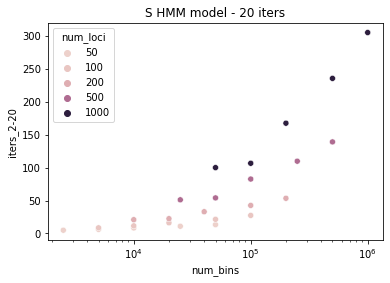

In [76]:
sns.scatterplot(data=s_runtime_df, x='num_bins', y='iters_2-20', hue='num_loci')
plt.title('S HMM model - {} iters'.format(num_iters))
plt.xscale('log')
plt.show()

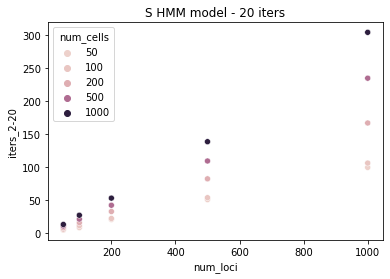

In [82]:
sns.scatterplot(data=s_runtime_df, x='num_loci', y='iters_2-20', hue='num_cells')
plt.title('S HMM model - {} iters'.format(20))
plt.show()

### Fit a linear model to the curve with 500 cells

In [87]:
from sklearn.linear_model import LinearRegression

X = s_runtime_df.query('num_cells==500')['num_loci'].values
y = s_runtime_df.query('num_cells==500')['sec_per_iter'].values
print(X)
print(y)
reg = LinearRegression().fit(X.reshape(-1, 1), y)


[  50  100  200  500 1000]
[ 0.60704499  1.18666916  2.36940895  6.11779397 13.04221752]


array([71.21467416])

In [89]:
# predict the per-iter runtime of a model containing all loci in the genome
full_genome_time_per_iter = reg.predict(np.array([5451]).reshape(-1,1))
full_genome_time_per_iter

array([71.21467416])

In [91]:
# compute how long it'd take to run 2k iters (in hours)
full_genome_time_per_iter * 2000 / 60 / 60

array([39.56370787])

### See how long the first HMM svi step takes when JIT is enabled

In [77]:
%%capture --no-stdout
sj_runtime_df = []
num_iters = 1
for n in range(25):
    for jit in [True]:
        
        conditioned_model_s = poutine.condition(
            model_S,
            data={}
        )
        optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
        
        if jit:
            elbo = JitTraceEnum_ELBO(max_plate_nesting=1)
        else:
            elbo = TraceEnum_ELBO(max_plate_nesting=1)
        
        guide = AutoDelta(
            poutine.block(conditioned_model_s, expose_fn=lambda msg: msg["name"].startswith("expose_"))
        )
        svi = SVI(conditioned_model_s, guide, optim, loss=elbo)
        u_guess_s = torch.mean(all_reads_norm_s[n]) / torch.mean(all_cns[n])
        
        pyro.clear_param_store()
        elbo.loss(conditioned_model_s, guide, all_gcs[n], betas=all_betas_g1[n], data=all_reads_norm_s[n], 
                  trans_mat=all_trans_mats[n], cn_prior=all_cn_priors[n])

        pyro.clear_param_store()
        
        
        start_time = time.time()
        for i in range(num_iters):
            loss = svi.step(all_gcs[n], betas=all_betas_g1[n], data=all_reads_norm_s[n], 
                            trans_mat=all_trans_mats[n], cn_prior=all_cn_priors[n])
        end_time = time.time()
        elapsed_time = end_time - start_time
        sec_per_iter = elapsed_time / num_iters
        
        temp_df = pd.DataFrame({'num_cells': [all_cns[n].shape[1]], 'num_loci': [all_cns[n].shape[0]],
                                'jit': [jit], 'sec_per_iter': [sec_per_iter],
                                'total_elapsed_time': [elapsed_time],
                                'num_iters': [num_iters]
                               })
        sj_runtime_df.append(temp_df)
        
        print('done with condition {} and jit=={}'.format(n, jit))

sj_runtime_df = pd.concat(sj_runtime_df, ignore_index=True)

done with condition 0 and jit==True
done with condition 1 and jit==True
done with condition 2 and jit==True
done with condition 3 and jit==True
done with condition 4 and jit==True
done with condition 5 and jit==True
done with condition 6 and jit==True
done with condition 7 and jit==True
done with condition 8 and jit==True
done with condition 9 and jit==True
done with condition 10 and jit==True
done with condition 11 and jit==True
done with condition 12 and jit==True
done with condition 13 and jit==True
done with condition 14 and jit==True
done with condition 15 and jit==True
done with condition 16 and jit==True
done with condition 17 and jit==True
done with condition 18 and jit==True
done with condition 19 and jit==True
done with condition 20 and jit==True
done with condition 21 and jit==True
done with condition 22 and jit==True
done with condition 23 and jit==True
done with condition 24 and jit==True


In [78]:
sj_runtime_df['num_bins'] = sj_runtime_df['num_cells'] * sj_runtime_df['num_loci']
sj_runtime_df.head()

,num_cells,num_loci,jit,sec_per_iter,total_elapsed_time,num_iters,num_bins
0,50,50,True,4.647802,4.647802,1,2500
1,100,50,True,4.706004,4.706004,1,5000
2,200,50,True,5.234204,5.234204,1,10000
3,500,50,True,5.287080,5.287080,1,25000
4,1000,50,True,5.761008,5.761008,1,50000


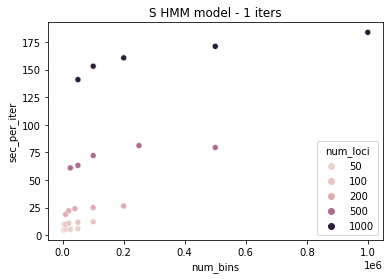

In [79]:
sns.scatterplot(data=sj_runtime_df, x='num_bins', y='sec_per_iter', hue='num_loci')
plt.title('S HMM model - {} iters'.format(num_iters))
plt.show()

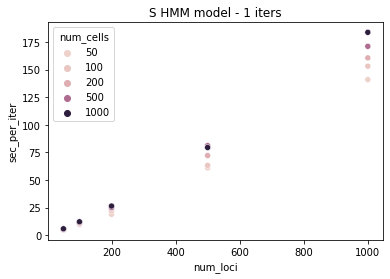

In [81]:
sns.scatterplot(data=sj_runtime_df, x='num_loci', y='sec_per_iter', hue='num_cells')
plt.title('S HMM model - {} iters'.format(num_iters))
plt.show()

### Wrangle the true and inferred values into a dataframe

In [ ]:
cn_s_out = []
for i in range(num_cells):
    temp_cn = rtdata.iloc[:num_loci]
    temp_cn['cell_id'] = 'cell_{}'.format(i)
    temp_cn['state'] = cn[:,i]
    temp_cn['reads'] = reads[:,i]
    temp_cn['reads_norm'] = reads_norm[:,i]
    temp_cn['true_rep'] = rep[:,i]
    temp_cn['true_u'] = u[i].numpy()
    temp_cn['true_time'] = time[i].numpy()
    temp_cn['true_nb_r'] = nb_r.detach().numpy()[0]
    temp_cn['true_a'] = a.numpy()[0]
    
    # results from model_S
    temp_cn['model1_rep'] = model_rep.numpy()[:,i]
    temp_cn['model1_time'] = trace.nodes["expose_time"]["value"][i].detach().numpy()
    temp_cn['model1_u'] = trace.nodes["expose_u"]["value"][i].detach().numpy()
    temp_cn['model1_nb_r'] = trace.nodes["expose_nb_r"]["value"][0].detach().numpy()
    temp_cn['model1_a'] = trace.nodes["expose_a"]["value"][0].detach().numpy()
    
    cn_s_out.append(temp_cn)
cn_s_out = pd.concat(cn_s_out, ignore_index=True)

In [ ]:
cn_s_out.head()

In [ ]:
for cell_id, chunk in cn_s_out.groupby('cell_id'):
    # add fraction of replicated bins per cell
    temp_rep0 = chunk.true_rep.values
    cn_s_out.loc[chunk.index, 'true_frac_rt'] = sum(temp_rep0) / temp_rep0.shape[0]
    temp_rep1 = chunk.model1_rep.values
    cn_s_out.loc[chunk.index, 'model1_frac_rt'] = sum(temp_rep1) / temp_rep1.shape[0]
    
    # add per-cell replication state acccuracy
    accuracy1 = 1.0 - (sum(abs(chunk['true_rep'] - chunk['model1_rep'])) / chunk.shape[0])
    cn_s_out.loc[chunk.index, 'model1_rep_acc'] = accuracy1
    
cn_s_out.head()

In [ ]:
cell_metrics = cn_s_out[['cell_id', 'true_a', 'true_nb_r', 'true_time', 'true_u', 'true_frac_rt', 'model1_rep_acc',
                         'model1_nb_r', 'model1_a', 'model1_time', 'model1_u', 'model1_frac_rt']].drop_duplicates()
cell_metrics.shape

In [ ]:
cell_metrics.head()

In [ ]:
loci_metrics = rtdata.iloc[:num_loci]
loci_metrics['true_bulk_rt'] = np.mean(rep.numpy(), axis=1)
loci_metrics['model1_bulk_rt'] = np.mean(model_rep.numpy(), axis=1)
loci_metrics.head()

### Evaluate performance of model1 (same as generative)

In [ ]:
sns.scatterplot(data=cell_metrics, x='true_time', y='model1_time', hue='model1_rep_acc', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=cell_metrics, x='true_u', y='model1_u', hue='model1_rep_acc', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=cell_metrics, x='true_frac_rt', y='model1_frac_rt', hue='model1_rep_acc', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=loci_metrics, x='true_bulk_rt', y='model1_bulk_rt', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=loci_metrics, x='norm_mcf7rt', y='model1_bulk_rt', alpha=0.3)
plt.show()

In [ ]:
sns.scatterplot(data=cell_metrics, x='model1_time', y='model1_u', hue='model1_rep_acc', alpha=0.3)
plt.show()